# Problem 1: K-means clustering and image compression (3pts)

### <div align="right"> &copy; Markiian Novosad & Rostyslav Hryniv, 2022 </div>

## Completed by:   
*   Nazar Andrushko
*   Roman Kovalchuk



### Description:
The aim of this assignment is to understand the K-means clustering algorithm and how it is used for image compression. You will implement the algorithm and then use it to assign the $m\times m$ blocks of the given image in $k$ clusters and then replace each block with the respective centroid. Visually, the quality of the image does not deteriorate much for moderate $m$ and large enough $k$, while its size drops down significantly as we only have to store the $k$ centroids and the cluster allocations of the blocks


### Links
For this task of your homework you can get **3 points** plus extra (see the last part).

To do some preliminary reading about K-Means algorithm, please check the following links:
*   https://scikit-learn.org/stable/modules/clustering.html
*   https://towardsdatascience.com/image-compression-using-k-means-clustering-aa0c91bb0eeb


### Initialization

In [1]:
!pip install requests numpy tqdm matplotlib scipy
!pip install torch torchvision


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [2]:
from PIL import Image
import requests
from io import BytesIO

url = "https://images.unsplash.com/photo-1611915387288-fd8d2f5f928b?ixlib=rb-4.0.3&w=1080&fit=max&q=80&fm=jpg&crop=entropy&cs=tinysrgb"
response = requests.get(url)
img = Image.open(BytesIO(response.content))

In [3]:
import torch
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
import numpy as np

In [4]:
def to_patches(img: torch.Tensor, psize) -> np.ndarray:
  return img.unfold(1, size=psize, step=psize).unfold(2,size=m, step=m).flatten(1,2).permute(1,0,2,3).numpy()

def visualize_patches(patches: np.ndarray, true_image_size=512, padding=0) -> Image:
  patch_tensor = torch.from_numpy(patches)
  return Image.fromarray(
      make_grid(patch_tensor, nrow=true_image_size // patches.shape[2], padding=padding
                ).permute(1,2,0).mul(255).to(torch.uint8).numpy())

## 1. K-Means Clustering from scratch (1 pt)

In this part, you will have to implement K-Means clustering algorithm for a dataset of points in $\mathbb{R}^n$. To this end, you are asked to implement the following methods:

*   random centroid initialization (choose random dataset points)
*   distance function
      *   Implement private methods with different distance metric (Euclidean, $\ell_1$, cosine, etc.)
*   allocation of points to clusters for given centroids
*   centroids update based on distance to all data points in respective clusters
*   and, finally, implement K-Means fitting loop, wich returns new fitted centroids





### Task 1: Complete the code below

In [13]:
import random
import numpy as np
from scipy.spatial.distance import cdist
from sklearn.metrics.pairwise import cosine_similarity

class KMeans:

  def __init__(
      self,
      num_clusters=1,
      num_features=1,
      max_iter=1000,
      epsilon=1e-6,
      dist_metric="euclidean"
    ) -> None:
    self.K = num_clusters
    self.C = num_features
    self.I = max_iter
    self.E = epsilon
    self.metric = dist_metric

  def init_centroids(self, X: np.ndarray) -> np.ndarray:
    """
    Initialize centroids in random manner
    """
    assert (self.C) == X.shape[1]
    centroids = np.zeros((self.K, self.C))
    # ========= YOUR CODE STARTS HERE ========= #
    centroids = np.random.random((self.K, self.C))

    # ========== YOUR CODE ENDS HERE ========== #
    return centroids

  def dist(self, X: np.ndarray, centroids: np.ndarray) -> np.ndarray:
    """
    Compute distance from each point to each centroid,
    depending on a self.metric type
    """
    # ========= YOUR CODE STARTS HERE ========= #
    if self.metric == 'euclidean':
      distances = cdist(X,centroids)
    if self.metric == 'cityblock':
      distances = cdist(X,centroids,metric='cityblock')
    if self.metric == 'cosine':
      distances = 1-cosine_similarity(X,centroids)
    # ========== YOUR CODE ENDS HERE ========== #
    return distances

  def calc_mask(self, X: np.ndarray, centroids: np.ndarray) -> np.ndarray:
    """
    Compute distance between data and centroids, pick closest centroid for each
    data point.
    """
    return self.dist(X, centroids).argmin(-1)

  def update_clusters(self, X: np.ndarray, centroids: np.ndarray) -> np.ndarray:
    """
    Compute new centroids, by computing the mean of each centroid's cluster.

    Hint: Beware, with high value of K, some clusters centroid's can become
    redundant, and have no points belonging to them.
    """
    mask = self.calc_mask(X, centroids)
    new_centroids = np.zeros_like(centroids)

    # ========= YOUR CODE STARTS HERE ========= #
    centroid_sums = np.zeros_like(new_centroids)
    np.add.at(centroid_sums, mask, X)
    centroid_counts = np.bincount(mask, minlength=new_centroids.shape[0])

    # Avoid division by zero
    centroid_counts[centroid_counts == 0] = 1

    # Update new centroids
    new_centroids = centroid_sums / centroid_counts[:, None]
    # ========== YOUR CODE ENDS HERE ========== #
    # print(new_centroids.shape, X.shape, mask.shape)
    return new_centroids

  def predict(self, X: np.ndarray, centroids: np.ndarray) -> np.ndarray:
    mask = self.calc_mask(X, centroids)
    return centroids[mask]

  def get_pop_art(self, X: np.ndarray, centroids: np.ndarray, custom_centroids: np.ndarray):
    mask = self.calc_mask(X, centroids)
    return custom_centroids[mask]
  
  def fit(self, X: np.ndarray) -> np.ndarray:
    """
    Implement training loop that looks like this:
    -- intiialize new centroids
    -- for max_iter steps:
      -- update centroids
      -- compute delta between old and new centroids
      -- return centroids if delta < epsilon

    """
    # ========= YOUR CODE STARTS HERE ========= #
    centroids = self.init_centroids(X)
    for i in range(self.I):
      new_centroids = self.update_clusters(X,centroids)
      if np.mean(np.linalg.norm(centroids - new_centroids, axis=1)) < self.E:
        break
      centroids = new_centroids
    return new_centroids
    # ========== YOUR CODE ENDS HERE ========== #


## 2. Image compression using K-Means clustering (0.5 pt)

The dataset for clustering will be the $m\times m$ patches of the initial image. We split the image into patches with helper function **to_patches()**

In [6]:
m = 16 # size of patch
img = img.resize((512,512))
img_tensor = ToTensor()(img) # 3, 512, 512

patches = to_patches(img_tensor, m)
patches.shape

(1024, 3, 16, 16)

Let's see how our splitted image looks:
(You can change padding from 0 to another value, to see the grid)

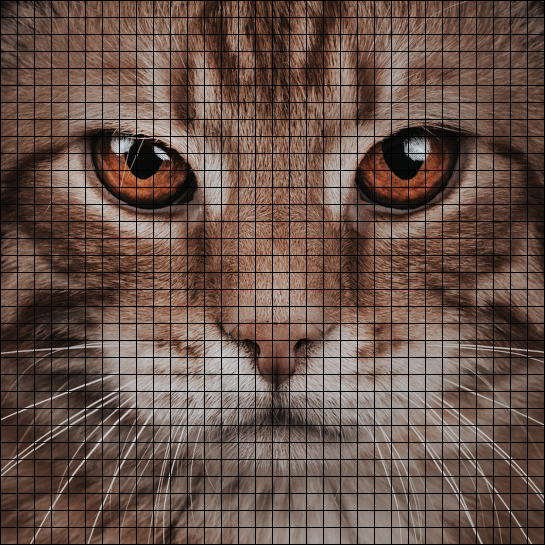

In [7]:
visualize_patches(patches, padding=1)

In [8]:
# convert patch data to feature vectors
data = patches.reshape(patches.shape[0], -1)
data.shape

(1024, 768)

### Try out your implementation!

In [9]:
# initialize KMeans algo
kmeans = KMeans(128, data.shape[-1], max_iter=400)
centroids = kmeans.fit(data)
predicted = kmeans.predict(data, centroids)


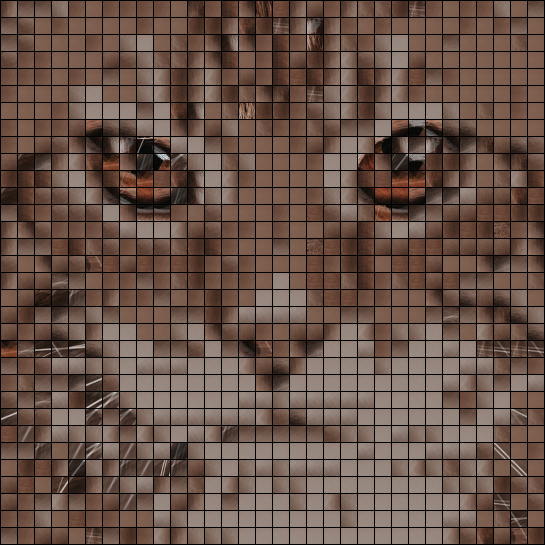

In [15]:
l2_image = visualize_patches(predicted.reshape(-1,3,m,m),padding=1)
l2_image

### Task 2: Discussion (0.5 pt)

 Using the implemented image compression algorithm, discuss the following topics:
1.  **Distance Metrics**: how do they influence of distance metrics on final result of fitting? (Provide visualizations and comments)
2.  **Compression rate**: what is the compression rate with different **k** (1,2,...,32) and **m**? What compression rate can we achieve without losing much quality?


In [16]:
# initialize KMeans algo
kmeans = KMeans(128, data.shape[-1], max_iter=400,dist_metric="cityblock")
centroids = kmeans.fit(data)
predicted = kmeans.predict(data, centroids)
cityblock_image = visualize_patches(predicted.reshape(-1,3,m,m),padding=1)


In [17]:
# initialize KMeans algo
kmeans = KMeans(128, data.shape[-1], max_iter=400,dist_metric="cosine")
centroids = kmeans.fit(data)
predicted = kmeans.predict(data, centroids)
cosine_image = visualize_patches(predicted.reshape(-1,3,m,m),padding=1)


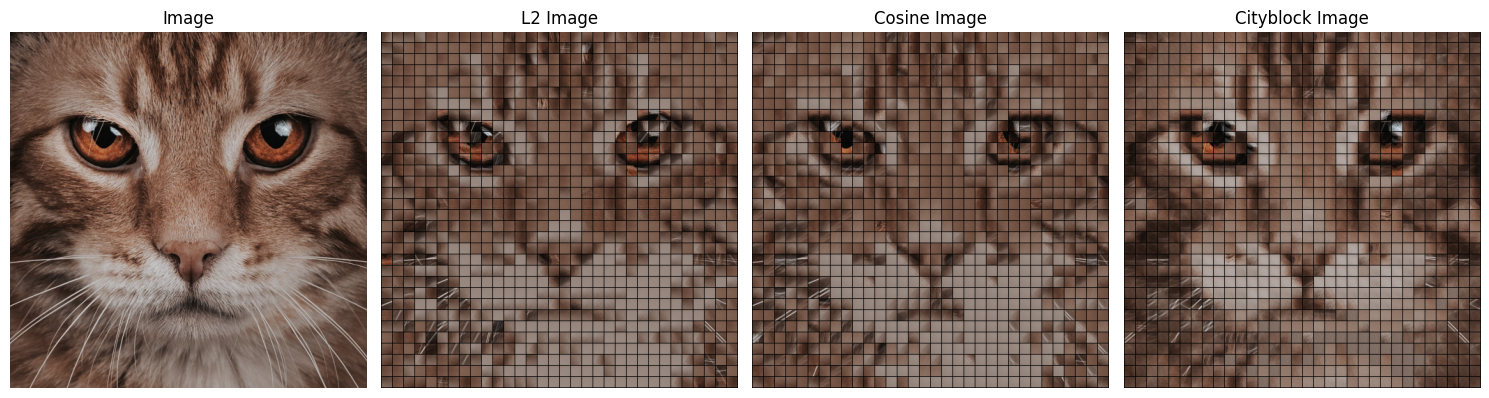

In [22]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 4, figsize=(15, 6))

# Hide the axes ticks and labels for a cleaner display
for ax in axes:
    ax.axis('off')

# Display each image on its respective subplot
axes[0].imshow(img)
axes[0].set_title('Image')

axes[1].imshow(l2_image)
axes[1].set_title('L2 Image')

axes[2].imshow(cosine_image)
axes[2].set_title('Cosine Image')

axes[3].imshow(cityblock_image)
axes[3].set_title('Cityblock Image')

plt.tight_layout()
plt.show()


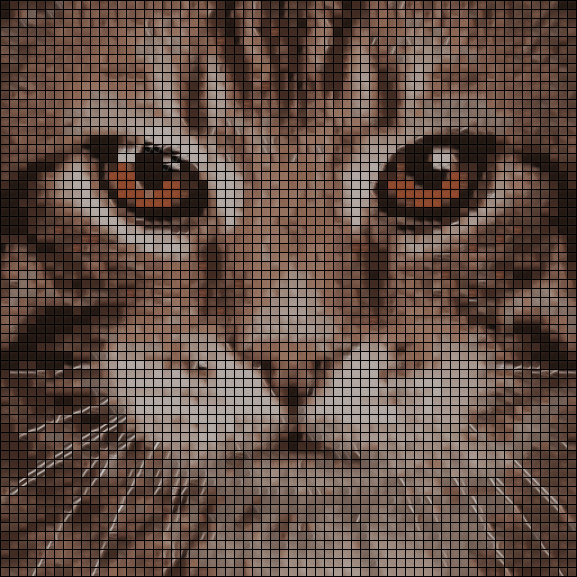

In [37]:
m = 8 # size of patch
img = img.resize((512,512))
img_tensor = ToTensor()(img) # 3, 512, 512

patches = to_patches(img_tensor, m)
# convert patch data to feature vectors
data = patches.reshape(patches.shape[0], -1)
data.shape
# initialize KMeans algo
kmeans = KMeans(90, data.shape[-1], max_iter=400,dist_metric="cityblock")
centroids = kmeans.fit(data)
predicted = kmeans.predict(data, centroids)
cityblock_image = visualize_patches(predicted.reshape(-1,3,m,m),padding=1)
cityblock_image

In [45]:
W = img.size[0]
H = img.size[1]
K = 90
compression_rate = (W * H * 3)/((K * m * m * 3) + (W // m)  * (H // m))
print(f"""
For K = {K}, H = {H}, W = {W}, m = {m}

Compression rate = {compression_rate}
""")


## init to previous settings 

m = 16 # size of patch
img = img.resize((512,512))
img_tensor = ToTensor()(img) # 3, 512, 512

patches = to_patches(img_tensor, m)
# convert patch data to feature vectors
data = patches.reshape(patches.shape[0], -1)


For K = 90, H = 512, W = 512, m = 8

Compression rate = 36.790419161676645



---

# 1. 

Let's compare results with different distance metric.

1. We can notice, that by using cityblock distance we kept pattern on the fur in a better way then when using cosine or euclidean distance.

2. L2 worked better (visually) comparing it to cosine, since, cosine has a lot of patches, for instace, where eyes are, that are not really matching original image.

Overall, visual ranking of KMeans compression on this particular image by metric would be something like this : 

cityblock > l2 > cosine.

# 2

- Compression Rate :

Original image size is (W,H,3) we compress it to patches with size m x m and K centroids with 3 x m x m features, therefore in compressed image we will have 

(W // m)  * (H // m) patches, for each of the patches we attach one centroid with m x m features.

So, in compressed image we have (W // m)  x (H // m) grid, where in each cell we have index of one of the K centroid with 3 x m x m features, therefore size is K x m x m + (W // m)  * (H // m). In better cases we don't actually use all centroids, so the K might decrease even to 1 if the image is consisting from only one color, for instance.

So the compression rate is $\frac{(W * H * 3)}{(K * m * m * 3) + (W // m)  * (H // m)}$

- What compression rate can we achieve without losing much quality :

It is highly debatable question, since, 'losing much quality' can be defined in a lot of ways, however, with approx. 90 clusters and pathces of size 8x8, image is quite noticable and things like whiskers are not lost, so we would suggest that this is an approximate setting for compressing this image. 

In this way we would compress image in almost 37 times. 

Another thing is that we can use Elbow method (from below), to find the best k and patch size, however this doesn't imply that found k and patch size would not 'lose too much quality'.

---

## 3. Elbow method (1 pt)

In this task, we will use the Elbow method to visualize the trade-off between quality and number of clusters **k** and try to select the best one!

##### To do some preliminary reading about Elbow Method, please, check the following link:
- https://stackabuse.com/k-means-clustering-with-the-elbow-method/

### Task 3: Implementation (0.3 pt)
Here we will implement the calculation of **Distortion** or **Inertia**, which are basically squared distances from each point to its assigned centroid.

In [46]:
## For each k run clustering algorithm and compute it's Distortion value
def calc_distoriton(data: np.ndarray, centroids:np.ndarray) -> float:
    distortion = 0
    # ========= YOUR CODE STARTS HERE ========= #
    kmeans = KMeans()
    predicted = kmeans.predict(data, centroids)
    euclidean_distances = np.linalg.norm(data - predicted, axis=1)
    distortion = np.sum(euclidean_distances)
    # ========== YOUR CODE ENDS HERE ========== #
    return distortion

In [48]:
kmeans = KMeans(128, data.shape[-1], max_iter=400)
centroids = kmeans.fit(data)

calc_distoriton(data,centroids)

2088.5098826147414

### Task 4: Calculate & Visualize (0.4 pt)
Let's use above implemented function to calculate distortion for some **k** values and visualize our results

In [49]:
from tqdm import tqdm
# You can choose your own values for the range
#(it may take some time to run the loop, so feel free to optimize your code ;=)
k_min = 2
k_max = 64
k_range = range(k_min, k_max, 2)

distortions = list()
#calculate distortion values
for k in tqdm(k_range):
  # ========= YOUR CODE STARTS HERE ========= #
  knn = KMeans(k,data.shape[-1],max_iter=400)
  centroids = knn.fit(data)
  distortions.append(calc_distoriton(data,centroids))
  # ========== YOUR CODE ENDS HERE ========== #

100%|██████████| 31/31 [00:58<00:00,  1.88s/it]


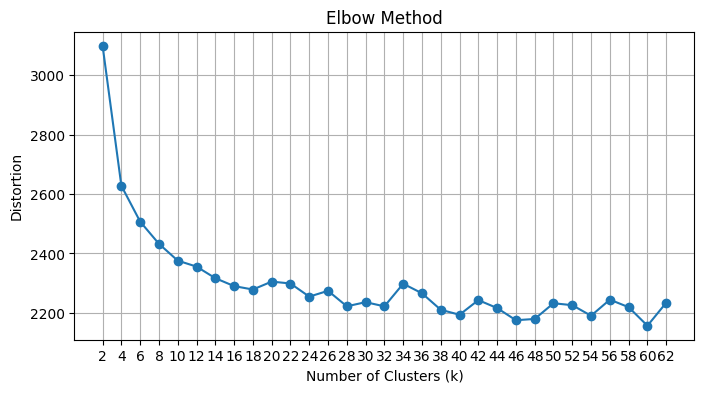

In [52]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 4))
plt.plot(k_range, distortions, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Distortion')
plt.xticks(k_range)
plt.grid(True)
plt.show()


In [55]:
W = img.size[0]
H = img.size[1]
K = 18
compression_rate = (W * H * 3)/((K * m * m * 3) + (W // m)  * (H // m))
print(f"""
For K = {K}, H = {H}, W = {W}, m = {m}

Compression rate = {compression_rate}
""")


For K = 18, H = 512, W = 512, m = 16

Compression rate = 52.96551724137931



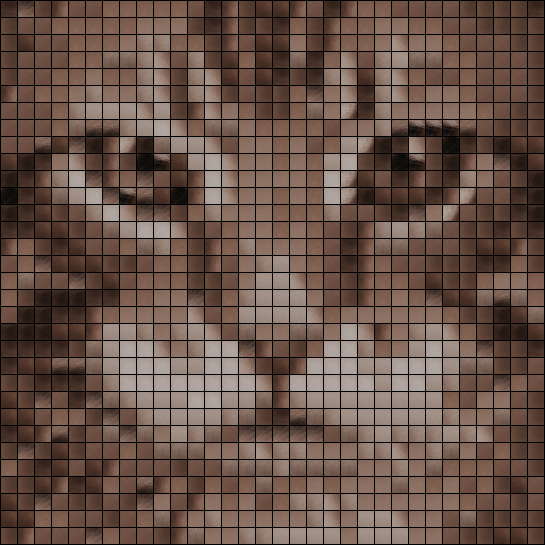

In [56]:
# initialize KMeans algo
kmeans = KMeans(18, data.shape[-1], max_iter=400)
centroids = kmeans.fit(data)
predicted = kmeans.predict(data, centroids)
visualize_patches(predicted.reshape(-1,3,m,m),padding=1)


In [60]:
distortions[8]

2278.418494033408

### Task 5: Summarize (0.3 pt)

Discuss your results: what is the best trade-off between number of clusters and distortion?

What is the compression rate with this optimal value?

---

The best trade-off between number of clusters and distortion is when k = 18, distortion = 2278.4, since with larger k distortion is not changing significantly.
The overall image, is quite good-looking, though it loses some features, such as whiskers. 


Compression rate is almost 53.

---

## 4. Conclusions (0.5 pt)

---

### Task 6 (0.5 pt)
Summarize in a few sentences what you have learned and achieved by completing the tasks of this assignment


By compliting this assignment we've learned about Elbow Method and how it can be used to determine the optimal number of k in Kmeans, learned more about internal KMeans implementation, and how different distance metrics influence the result of KMeans clustering in image compression.


Regarding our achievements, we've made our compression algorithm, which is based on Kmeans clustering and compressed image almost in 53 times, without loosing to much quality.

## 5. Bonus Problem (0.5 pt)
Besides compression, K-Means clustering can be used in more "creative" way -- using bigger patch sizes we can create cool "pop-art" mosaics :=)

*Hint*: you can replace fitted centroids with your own patches.

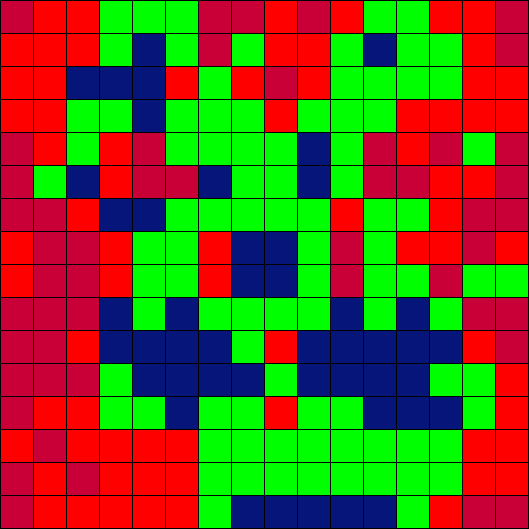

In [64]:
# ========= YOUR CODE STARTS HERE ========= #
m = 32  # size of patch
img = img.resize((512, 512))
img_tensor = ToTensor()(img)
patches = to_patches(img_tensor, m)
data = patches.reshape(patches.shape[0], -1)

kmeans = KMeans(6, data.shape[-1], max_iter=400)

color1 = np.full((m , m , 3), [255, 0, 0], dtype=np.float16)  # Red patch
color2 = np.full((m , m , 3), [0, 255, 0], dtype=np.float16)  # Green patch
color3 = np.full((m , m , 3), [0, 0, 255], dtype=np.float16)  # Blue patch
color4 = np.full((m , m , 3), [5, 21, 121], dtype=np.float16)  # Blue patch
color5 = np.full((m , m , 3), [201, 0, 55], dtype=np.float16)  # Blue patch
color6 = np.full((m , m , 3), [0, 210, 35], dtype=np.float16)  # Blue patch
custom_patches = np.array([to_patches(ToTensor()(color1),m), to_patches(ToTensor()(color2),m), to_patches(ToTensor()(color3),m),
                        to_patches(ToTensor()(color4),m), to_patches(ToTensor()(color5),m), to_patches(ToTensor()(color6),m) ])

custom_patches = custom_patches.reshape(custom_patches.shape[0], -1)

centroids = kmeans.fit(data)

# Predict clusters for the data based on real clusters, and replace value with custom centroids
predicted = kmeans.get_pop_art(patches.reshape(patches.shape[0], -1), centroids,np.array([random.choice(custom_patches) for _ in range(centroids.shape[0])]))




# Visualize the predicted patches with your custom centroids
visualize_patches(predicted.reshape(-1, 3, m, m)/255, padding=1)
# ========== YOUR CODE ENDS HERE ========== #